# Relevant Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from confeddi import FederatedSystem
from distribute_data import generate_data

import random
import os
from tensorflow.random import set_seed

# Preprocess Data

### Load RTT Data

In [2]:
data = pd.read_csv('RTT_data.csv')

# Getting rid of complex-valued columns
data = data.select_dtypes(exclude = ['object'])

# Quick look at data
print(f'Number of samples: {data.shape[0]}')
print(f'Features per sample: {data.shape[1] - 1}\n')
print(f'Columns:')
for i in data.columns[:-1]:
    if i == 'GroundTruthRange[m]':
        continue
    print(f'{i}, ', end = '')
print(data.columns[-1], end = '')


# Separate data and labels
X = data.drop(columns = ['GroundTruthRange[m]']).to_numpy()
y = data['GroundTruthRange[m]'].to_numpy()

Number of samples: 29581
Features per sample: 10

Columns:
%Timestamp[s], GroundTruthPositionX[m], GroundTruthPositionY[m], GroundTruthPositionZ[m], ML_range_estimate[m], AP_positionX[m], AP_positionY[m], AP_positionZ[m], AP_index, ToD_factor[m]

### Distribute data among clients

In [3]:
seed = 11

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = seed)

data = generate_data(X_train, y_train, seed = seed)
scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)
X = scaler.fit_transform(X)

fed = FederatedSystem(data['Client Data'], data['Client Labels'], data['Client Distances'])
fed.V = {'Val Data': X_val, 'Val Labels': y_val}
fed.set_test_data({'Data': X, 'Labels': y})

In [4]:
# usually test with .1 .1
#fed.SetContextElements([0])
#w, b = fed.ConFeddi(10, 10, rounds = 1)

In [6]:
tf.keras.utils.set_random_seed(50)
tf.config.experimental.enable_op_determinism()

fed = FederatedSystem(data['Client Data'], data['Client Labels'], data['Client Distances'])
fed.V = {'Val Data': X_val, 'Val Labels': y_val}
fed.set_test_data({'Data': X, 'Labels': y})
fed.SetContextElements([1, 2, 3])
w1, m1 = fed.ConFeddi(10, 10, rounds = 10)

fed = FederatedSystem(data['Client Data'], data['Client Labels'], data['Client Distances'])
fed.V = {'Val Data': X_val, 'Val Labels': y_val}
fed.set_test_data({'Data': X, 'Labels': y})
fed.SetContextElements([1, 2, 3])
w2, m2 = fed.ConFeddi(10, 10, rounds = 10)


total = 0
for i, j in zip(w1, w2):
    for idx in range(3):
        print(f'Layer {idx}: ', end = '')
        print(np.sum(i[idx] != j[idx]))
        total += np.absolute(np.sum(i[idx] - j[idx]))
        print(f'Cumsum: {total}')
    print()



Round 1
[1 9 4 2]
Round 2
[2 1 9 4]
Round 3
[2 9]
Round 4
[2 9 8 7 6 5]
Round 5
[7 8 6 2 9 5 4 3 1]
Round 6
[7 2 8 6 9 5 1 4]
Round 7
[7]
Round 8
[7 9 8 6 5 4]
Round 9
[7 8 6 5]
Round 10
[8 7 6 5 9 4]
Round 1
[1 9 4 2]
Round 2
[2 1 9 4]
Round 3
[2 9]
Round 4
[2 9 8 7 6 5]
Round 5
[7 8 6 2 9 5 4 3 1]
Round 6
[7 2 8 6 9 5 1 4]
Round 7
[7]
Round 8
[7 9 8 6 5 4]
Round 9
[7 8 6 5]
Round 10
[8 7 6 5 9 4]
Layer 0: 0
Cumsum: 0.0
Layer 1: 0
Cumsum: 0.0
Layer 2: 0
Cumsum: 0.0

Layer 0: 0
Cumsum: 0.0
Layer 1: 0
Cumsum: 0.0
Layer 2: 0
Cumsum: 0.0

Layer 0: 0
Cumsum: 0.0
Layer 1: 0
Cumsum: 0.0
Layer 2: 0
Cumsum: 0.0



In [31]:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 1, inter_op_parallelism_threads = 1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
set_session(sess)
set_seed(50)
tf.compat.v1.set_random_seed(50)
np.random.seed(50)
os.environ['PYTHONHASHSEED'] = '50'

X = data['Client Data'][6]
y = data['Client Labels'][6]
w, b = fed.initialize_weights()

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 1, inter_op_parallelism_threads = 1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
set_session(sess)
set_seed(50)
tf.compat.v1.set_random_seed(50)
np.random.seed(50)
os.environ['PYTHONHASHSEED'] = '50'

w1, b1, model, history = fed.ClientUpdate(X, y, w, b, 5)
w2, b2, model, history = fed.ClientUpdate(X, y, w, b, 5)

for i, j in zip(w1, w2):
    print(np.sum(i != j))

11
19
1


In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## GLOBAL SEED ##                                                   
tf.random.set_seed(3)
x_train = tf.random.normal((10,1), 1, 1, dtype=tf.float32)
y_train = tf.math.sin(x_train)
x_test = tf.random.normal((10,1), 2, 3, dtype=tf.float32)
y_test = tf.math.sin(x_test)

model = Sequential()
model.add(Dense(1200, input_shape=(1,), activation='relu'))  
model.add(Dense(150, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 

loss="binary_crossentropy"
optimizer=tf.keras.optimizers.Adam(lr=0.01)
metrics=['mse']
epochs = 5
batch_size = 32
verbose = 1

model.compile(loss=loss,  
              optimizer=optimizer, 
              metrics=metrics) 
histpry = model.fit(x_train, y_train, epochs = epochs, batch_size=batch_size, verbose = verbose)
predictions = model.predict(x_test)
print(predictions)

Epoch 1/5
1/1 [==============================] - 0s 328ms/step - loss: 0.6955 - mse: 0.3109
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.6731 - mse: 0.2997
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.4672 - mse: 0.2078
Epoch 4/5
1/1 [==============================] - 0s 35ms/step - loss: 0.1316 - mse: 0.1211
Epoch 5/5
1/1 [==============================] - 0s 47ms/step
[[9.9467409e-01]
 [9.5628178e-01]
 [9.9657851e-01]
 [9.6684474e-01]
 [3.7888515e-09]
 [8.9169466e-01]
 [9.3267453e-01]
 [8.3166295e-01]
 [9.8976678e-01]
 [2.6092320e-13]]


In [ ]:
w1, b1, model1, history = fed.ClientUpdate(data['Client Data'][4], data['Client Labels'][4], w, b, 5)

In [ ]:
w2, b2, model2, history = fed.ClientUpdate(data['Client Data'][4], data['Client Labels'][4], w, b, 5)

In [ ]:
for i, j in zip(w1, w2):
    print(np.sum(i != j))

320
512
16


In [ ]:
np.sum(model1.get_weights()[0] != model2.get_weights()[0])

103

In [ ]:
m1, m2 = fed.generate_model(w, b), fed.generate_model(w, b)
np.sum(m1.get_weights()[0] != m2.get_weights()[0])

0

In [16]:
fed.trainable_layers

[0, 1, 2]

In [60]:
mse_losses, mae_losses = fed.test_acc()

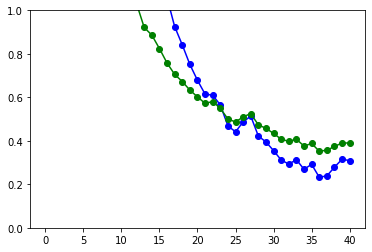

In [61]:
x = range(41)
plt.ylim(0, 1)
plt.plot(x, mse_losses, color = 'blue', marker = 'o')
plt.plot(x, mae_losses, color = 'green', marker = 'o')

In [27]:
model = fed.generate_model(w, b)

In [28]:
model.predict(X)

925/925 [==============================] - 1s 949us/step


array([[30.452354 ],
       [23.151384 ],
       [25.679396 ],
       ...,
       [13.964169 ],
       [ 6.8701057],
       [ 7.191533 ]], dtype=float32)

In [29]:
y[0]

31.047

In [30]:
y[1]

23.051

In [31]:
y[-1]

6.9716

In [32]:
y[-2]

7.2991

In [33]:
y[-3]

13.833